## VK parsed data processing

In [45]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

sns.set()
%matplotlib inline

In [42]:
def moviesmusic(raw):
    if raw is not np.nan:
        raw = re.sub('[":«»]', '', raw)
        raw = raw.lower()
        temp = []
        for i in re.split(r'[,\;]+', raw):
            i = re.sub(r'\(.+\)', '', i)
            if i != ' ' and not bool(re.match(r'^\d+|^\s+', i.strip())):
                temp.append(i.strip())
            else:
                continue
        return temp


def bdays(raw, type='day'):
    raw = str(raw)
    if raw == np.nan or raw == 'nan':
        return np.nan
    if type == 'day':
        return np.int64(raw.split('.')[0].strip())
    elif len(raw.split('.')) == 2 and type == 'month':
        return np.int64(raw.split('.')[1].strip())
    elif len(raw.split('.')) == 3 and type == 'month':
        return np.int64(raw.split('.')[1].strip())
    elif len(raw.split('.')) == 3 and type == 'year':
        return np.int64(raw.split('.')[2].strip())
    else:
        return np.nan


def adopttocal(art):
    #########################################################################
    # function builds dictionary of Counters.                               #
    # key is the item and the value is counter in which                     #
    # it counts all the occurences with other items                         #
    # then, getting the item(art, name, or whatever) by key                 #
    # you will get the Counter (sorted by number of occurences eventually)  #
    # with all the recommended items                                        #
    # NOTE: to collect this dict it requires the big datasets               #
    #########################################################################
    for item in art:
        if item in catalog.keys():
            temp = catalog[item]
            for item_2 in art:
                if item_2 != item: # exclude self counting
                    temp[item_2] += 1
        else:
            temp = Counter()
            for item_2 in art:
                if item_2 != item: # exclude self counting
                    temp[item_2] += 1
            catalog[item] = temp

In [102]:
df = pd.read_csv('vk.csv', sep=';', header=None)
df.columns = ['uid', 'name', 'surname', 'sex', 'country', 'city', 'bday', 'music', 'movies']
df['sex'] = df['sex'].astype(dtype='Int64')

### Music analyse block

In [103]:
df['music'] = df['music'].apply(lambda x: moviesmusic(x))
df2 = df[['sex', 'music']].dropna()
df2 = df2.explode('music', ignore_index=True)

In [104]:
top_music = df2['music'].value_counts().head(20)

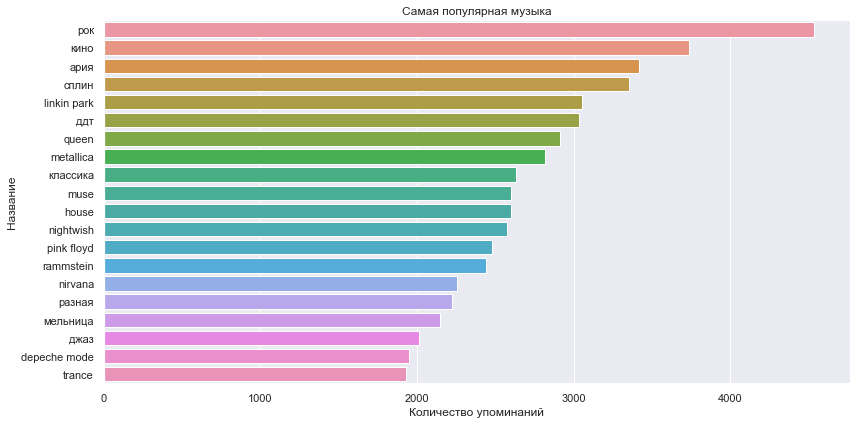

In [105]:
plt.figure(figsize=(12, 6))
sns.barplot(orient='h', x=top_music.values, y=top_music.index)
plt.title('Самая популярная музыка')
plt.xlabel('Количество упоминаний')
plt.ylabel('Название')
plt.tight_layout()
plt.savefig('top_music.jpg');

In [39]:
groups = ['pink floyd']

df2 = df2[df2['music'].isin(groups)]
print('Groups: {}\nNumber of records: {}\n'.format(groups, df2.shape[0]))

df2 = df2.groupby('sex', as_index=False).count()
df2['sex'] = df2['sex'].map({2: 'male', 1: 'female'})
df2['music'] = df2['music'] / df2['music'].sum() * 100
df2

Groups: ['pink floyd']
Number of records: 2480



,sex,music
0,female,23.709677
1,male,76.290323


In [57]:
df2 = df['movies'].dropna().apply(lambda x: moviesmusic(x))
df2['movies'] = df2.explode('movies')

In [69]:
top_movies = df2['movies'].value_counts().head(20)

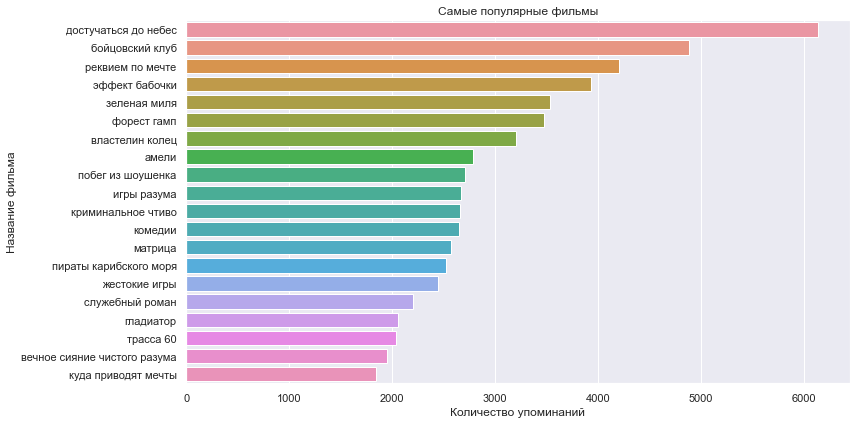

In [95]:
plt.figure(figsize=(12, 6))
sns.barplot(orient='h', x=top_movies.values, y=top_movies.index)
plt.title('Самые популярные фильмы')
plt.xlabel('Количество упоминаний')
plt.ylabel('Название фильма')
plt.tight_layout()
plt.savefig('top_movies.jpg');

### Recomendation system
#### some kind of dummy collaborative filtration

In [98]:
catalog = {}
df2 = df['movies'].dropna().apply(lambda x: moviesmusic(x))
df2.apply(adopttocal);

In [99]:
movie = 'терминатор'
number = 10
print('\nTop {} recommended items for '.format(str(rec_number)), movie, ':')
for art, _ in catalog[movie].most_common(number):
    print(art)


Top 10 recommended items for  терминатор :
матрица
властелин колец
назад в будущее
пираты карибского моря
крепкий орешек
гладиатор
хищник
эффект бабочки
трансформеры
аватар


### Age distribution

In [89]:
df['year'] = df['bday'].apply(lambda x: bdays(x, type='year'))
df2 = df[['year', 'sex']].dropna()
df2['age'] = 2020 - df2['year'].astype(np.int64)
df2 = df2[df2['age'] < 70]
df2['sex'] = df2['sex'].apply(lambda x: 'муж' if x == 2 else 'жен')
df2.head()

,year,sex,age
0,1984.0,муж,36
12,1982.0,муж,38
16,1985.0,муж,35
17,1986.0,муж,34
19,1986.0,муж,34


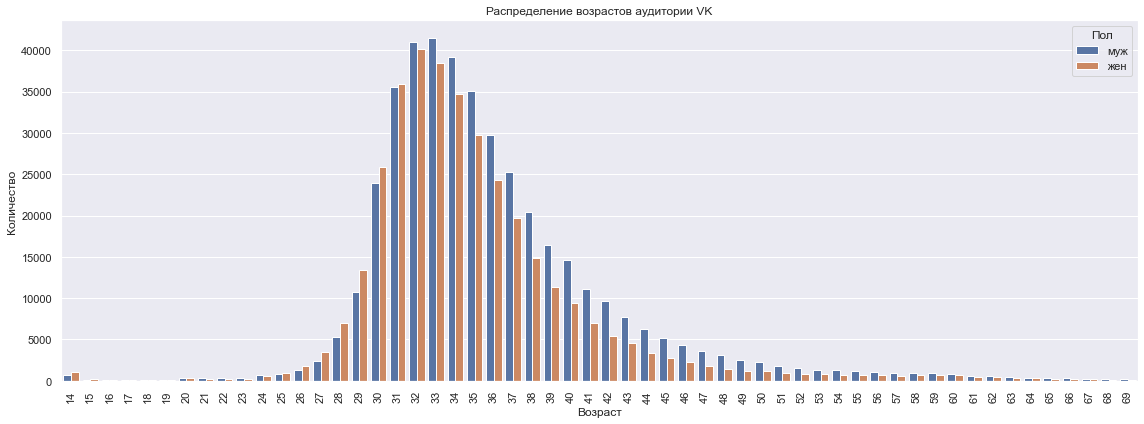

In [93]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.countplot(data=df2, x='age', hue='sex')
plt.title('Распределение возрастов аудитории VK')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(title='Пол')
plt.tight_layout()
plt.savefig('sex_dist.jpg')